## PyArgum 

pyAgrum is a scientific C++ and Python library dedicated to Bayesian networks (BN) and other Probabilistic Graphical Models. Based on the C++ aGrUM library, it provides a high-level interface to the C++ part of aGrUM allowing to create, manage and perform efficient computations with Bayesian networks and others probabilistic graphical models : Markov random fields (MRF), influence diagrams (ID) and LIMIDs, credal networks (CN), dynamic BN (dBN), probabilistic relational models (PRM). 

References: https://pyagrum.readthedocs.io/en/1.17.2/

## Requirement installation 

In [1]:
pip install pyArgum

ERROR: Could not find a version that satisfies the requirement pyArgum (from versions: none)
ERROR: No matching distribution found for pyArgum

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas openpyxl


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [3]:
import matplotlib.pyplot as plt

# import the computation tools of aGrUM
import pyAgrum as gum

# import the graphical display functions
import pyAgrum.lib.notebook as gnb


## Step1: Load the Excel Dataset in Python

In [4]:
import pandas as pd

# Load the dataset
file_path = "asthama.xlsx"  # Replace with your actual file path
data = pd.read_excel(file_path, engine="openpyxl")

# Display the first few rows
print(data.head())

       ID  ID.1             Name              Location Temparature  Humidity   \
0   77516  2101  Patrick Mahomes     Chisinau, Moldova         5°C       0.15   
1   83311  2102   Julian Edelman     Glasgow, Scotland        25°C       0.80   
2  215646  2103       Nick Foles     Chisinau, Moldova        10°C       0.12   
3  234721  2104        Tom Brady     Chicago, Illinois        12°C       0.10   
4  338409  2105       Von Miller  Salt Lake City, Utah        13°C       0.09   

  Air Freshness                Date       Time  
0          Good  2010-07-01 00:00:00  05:07:00  
1         Fresh  2010-07-02 00:00:00  21:10:00  
2         Fresh  2010-07-06 00:00:00  08:12:00  
3         Fresh  2018-09-05 00:00:00  09:56:00  
4          Good           16/12/2017  09:55:00  


The column name has spaces or incorrect formatting, renaming in proper date and time

In [5]:
data.columns = data.columns.str.strip()  # Remove spaces from column names

# Rename the Date column if needed
data.rename(columns={' date': 'Date', 'DATE': 'Date'}, inplace=True)

print(data.columns)  # Check again


Index(['ID', 'ID.1', 'Name', 'Location', 'Temparature', 'Humidity',
       'Air Freshness', 'Date', 'Time'],
      dtype='object')


## Step2: Preprocess the Dta

While loading Excel dataset, checking if any columns contain datetime values that might be causing issues when learning the Bayesian Network. Before prerpocessing the data converting them to timedelta or categorical values:

In [6]:
# Before preprocess fixing the date and time 
# Convert 'Date' column to a standard format
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', dayfirst=True)  # Auto-fix different formats

# Convert 'Time' column to standard time format
data['Time'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.time


# If 'Time' column is in string format and handle missing values
data['Time'] = data['Time'].astype(str).fillna('00:00:00')

print(data[['Date', 'Time']].head())

        Date      Time
0 2010-07-01  05:07:00
1 2010-07-02  21:10:00
2 2010-07-06  08:12:00
3 2018-09-05  09:56:00
4 2017-12-16  09:55:00


In [7]:
#Verify If "Date" is Loaded Properly

print(data.head())  # See the first few rows
print(data.info())  # Check column data types

       ID  ID.1             Name              Location Temparature  Humidity  \
0   77516  2101  Patrick Mahomes     Chisinau, Moldova         5°C      0.15   
1   83311  2102   Julian Edelman     Glasgow, Scotland        25°C      0.80   
2  215646  2103       Nick Foles     Chisinau, Moldova        10°C      0.12   
3  234721  2104        Tom Brady     Chicago, Illinois        12°C      0.10   
4  338409  2105       Von Miller  Salt Lake City, Utah        13°C      0.09   

  Air Freshness       Date      Time  
0          Good 2010-07-01  05:07:00  
1         Fresh 2010-07-02  21:10:00  
2         Fresh 2010-07-06  08:12:00  
3         Fresh 2018-09-05  09:56:00  
4          Good 2017-12-16  09:55:00  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ID             500 non-null    int64         
 1   ID.1           500 non-

In [8]:
#Now, let’s combine the Date & Time into a single datetime column.

# Merge Date and Time into a single datetime column
data['Datetime'] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str), errors='coerce')

# Drop the old columns
data.drop(columns=['Date', 'Time'], inplace=True)

print(data[['Datetime']].head())


             Datetime
0 2010-07-01 05:07:00
1 2010-07-02 21:10:00
2 2010-07-06 08:12:00
3 2018-09-05 09:56:00
4 2017-12-16 09:55:00


*** Extract Useful Features from Datetime
Since pyAgrum doesn't work with datetime, we extract useful categorical features:

Hour of the Day (Morning, Afternoon, Evening, Night)
Day of the Week (Monday, Tuesday, etc.)
Month of the Year
Is Weekend? (Yes/No)

In [9]:
# Extract features from Datetime
data['Hour'] = data['Datetime'].dt.hour
data['DayOfWeek'] = data['Datetime'].dt.day_name()
data['Month'] = data['Datetime'].dt.month
data['IsWeekend'] = data['Datetime'].dt.weekday >= 5  # True if Sat/Sun

# Map hours to part of the day
data['TimeCategory'] = pd.cut(data['Hour'], bins=[0, 6, 12, 18, 24], labels=["Night", "Morning", "Afternoon", "Evening"])

print(data[['Hour', 'DayOfWeek', 'Month', 'IsWeekend', 'TimeCategory']].head())


   Hour  DayOfWeek  Month  IsWeekend TimeCategory
0   5.0   Thursday    7.0      False        Night
1  21.0     Friday    7.0      False      Evening
2   8.0    Tuesday    7.0      False      Morning
3   9.0  Wednesday    9.0      False      Morning
4   9.0   Saturday   12.0       True      Morning


*** Since pyAgrum works with numbers, we need to convert Location, Air Freshness, DayOfWeek, etc., into numerical values.

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode categorical variables
label_encoder = LabelEncoder()
data['Location'] = label_encoder.fit_transform(data['Location'])
data['Air Freshness'] = label_encoder.fit_transform(data['Air Freshness'])
data['DayOfWeek'] = label_encoder.fit_transform(data['DayOfWeek'])
data['TimeCategory'] = label_encoder.fit_transform(data['TimeCategory'])

print(data.head())


       ID  ID.1             Name  Location Temparature  Humidity  \
0   77516  2101  Patrick Mahomes        31         5°C      0.15   
1   83311  2102   Julian Edelman        61        25°C      0.80   
2  215646  2103       Nick Foles        31        10°C      0.12   
3  234721  2104        Tom Brady        29        12°C      0.10   
4  338409  2105       Von Miller       172        13°C      0.09   

   Air Freshness            Datetime  Hour  DayOfWeek  Month  IsWeekend  \
0              2 2010-07-01 05:07:00   5.0          4    7.0      False   
1              1 2010-07-02 21:10:00  21.0          0    7.0      False   
2              1 2010-07-06 08:12:00   8.0          5    7.0      False   
3              1 2018-09-05 09:56:00   9.0          6    9.0      False   
4              2 2017-12-16 09:55:00   9.0          2   12.0       True   

   TimeCategory  
0             3  
1             1  
2             2  
3             2  
4             2  


## Normalize Temperature & Humidity

Temperature column has values like "5°C", which need to be converted to numbers.

In [11]:
data.columns = data.columns.str.strip()  # Remove spaces
data.rename(columns={'Temparature': 'Temperature'}, inplace=True)  # Fix spelling

In [12]:
# Remove '°C' and convert to float
data['Temperature'] = data['Temperature'].str.replace('°C', '').astype(float)

# Normalize numerical columns
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[['Temperature', 'Humidity']] = scaler.fit_transform(data[['Temperature', 'Humidity']])

print(data.head())


       ID  ID.1             Name  Location  Temperature  Humidity  \
0   77516  2101  Patrick Mahomes        31     0.000000  0.141414   
1   83311  2102   Julian Edelman        61     0.571429  0.797980   
2  215646  2103       Nick Foles        31     0.142857  0.111111   
3  234721  2104        Tom Brady        29     0.200000  0.090909   
4  338409  2105       Von Miller       172     0.228571  0.080808   

   Air Freshness            Datetime  Hour  DayOfWeek  Month  IsWeekend  \
0              2 2010-07-01 05:07:00   5.0          4    7.0      False   
1              1 2010-07-02 21:10:00  21.0          0    7.0      False   
2              1 2010-07-06 08:12:00   8.0          5    7.0      False   
3              1 2018-09-05 09:56:00   9.0          6    9.0      False   
4              2 2017-12-16 09:55:00   9.0          2   12.0       True   

   TimeCategory  
0             3  
1             1  
2             2  
3             2  
4             2  


Now, let’s drop irrelevant columns like ID, Name, and Datetime (since we've extracted features from it).

In [13]:
data.drop(columns=['ID', 'ID.1', 'Name', 'Datetime'], inplace=True)

print(data.head())


   Location  Temperature  Humidity  Air Freshness  Hour  DayOfWeek  Month  \
0        31     0.000000  0.141414              2   5.0          4    7.0   
1        61     0.571429  0.797980              1  21.0          0    7.0   
2        31     0.142857  0.111111              1   8.0          5    7.0   
3        29     0.200000  0.090909              1   9.0          6    9.0   
4       172     0.228571  0.080808              2   9.0          2   12.0   

   IsWeekend  TimeCategory  
0      False             3  
1      False             1  
2      False             2  
3      False             2  
4       True             2  


## Convert Data to pyAgrum-Compatible Format


In [14]:
data_numpy = data.to_numpy()


## Build Bayesian Network with pyAgrum

In [15]:
import pandas as pd

# Define column names (update these based on your dataset)
column_names = ["Location", "Temperature", "Humidity", "Air Freshness", "Hour", "DayOfWeek", "Month", "IsWeekend", "TimeCategory"]

# Convert NumPy array to DataFrame
data_df = pd.DataFrame(data_numpy, columns=column_names)

# Check the DataFrame
print(data_df.head())


  Location Temperature  Humidity Air Freshness  Hour DayOfWeek Month  \
0       31         0.0  0.141414             2   5.0         4   7.0   
1       61    0.571429   0.79798             1  21.0         0   7.0   
2       31    0.142857  0.111111             1   8.0         5   7.0   
3       29         0.2  0.090909             1   9.0         6   9.0   
4      172    0.228571  0.080808             2   9.0         2  12.0   

  IsWeekend TimeCategory  
0     False            3  
1     False            1  
2     False            2  
3     False            2  
4      True            2  


In [16]:
# Fill missing numerical values with mean
data_df['Temperature'] = data_df['Temperature'].fillna(data_df['Temperature'].mean())
data_df['Humidity'] = data_df['Humidity'].fillna(data_df['Humidity'].mean())

# Fill missing categorical values with mode (most common value)
data_df['Location'] = data_df['Location'].fillna(data_df['Location'].mode()[0])
data_df['Air Freshness'] = data_df['Air Freshness'].fillna(data_df['Air Freshness'].mode()[0])


/var/folders/13/vfvs2bkn5wj31xbp8hlphjh80000gn/T/ipykernel_43199/1005340728.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df['Temperature'] = data_df['Temperature'].fillna(data_df['Temperature'].mean())
/var/folders/13/vfvs2bkn5wj31xbp8hlphjh80000gn/T/ipykernel_43199/1005340728.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_df['Humidity'] = data_df['Humidity'].fillna(data_df['Humidity'].mean())
/var/folders/13/vfvs2bkn5wj31xbp8hlphjh80000gn/T/ipykernel_43199/1005340728.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, 

In [17]:
print(data_df.isnull().sum())  # Check for missing values


Location         0
Temperature      0
Humidity         0
Air Freshness    0
Hour             6
DayOfWeek        0
Month            6
IsWeekend        0
TimeCategory     0
dtype: int64


In [22]:
data_df.dropna(inplace=True)

In [23]:
print(data_df.isnull().sum()) 

Location         0
Temperature      0
Humidity         0
Air Freshness    0
Hour             0
DayOfWeek        0
Month            0
IsWeekend        0
TimeCategory     0
dtype: int64


In [24]:
print(data_df.head())

   Location  Temperature  Humidity  Air Freshness  Hour DayOfWeek Month  \
0        31            0  0.141414              2   5.0         4   7.0   
1        61            2  0.797980              1  21.0         0   7.0   
2        31            0  0.111111              1   8.0         5   7.0   
3        29            0  0.090909              1   9.0         6   9.0   
4       172            0  0.080808              2   9.0         2  12.0   

  IsWeekend TimeCategory  
0     False            3  
1     False            1  
2     False            2  
3     False            2  
4      True            2  


In [25]:
from sklearn.preprocessing import KBinsDiscretizer

# Apply discretization (equal-width bins)
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_df["Temperature"] = discretizer.fit_transform(data_df[["Temperature"]])

# Convert to integer
data_df["Temperature"] = data_df["Temperature"].astype(int)


/Users/abishekshrestha/Documents/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [26]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_df["Hour"] = discretizer.fit_transform(data_df[["Hour"]])

# Convert to integer
data_df["Hour"] = data_df["Hour"].astype(int)


/Users/abishekshrestha/Documents/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [27]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_df["Humidity"] = discretizer.fit_transform(data_df[["Humidity"]])

# Convert to integer
data_df["Humidity"] = data_df["Humidity"].astype(int)


/Users/abishekshrestha/Documents/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [28]:
from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform')
data_df["Month"] = discretizer.fit_transform(data_df[["Month"]])

# Convert to integer
data_df["Month"] = data_df["Month"].astype(int)

/Users/abishekshrestha/Documents/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [38]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Use the DataFrame directly
learner = gum.BNLearner(data_df)
bn = learner.learnBN()

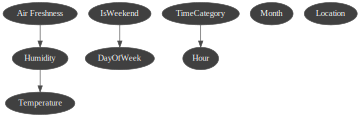

In [39]:
# Display the learned Bayesian Network
gnb.showBN(bn)

In [40]:
print(bn.names())

{'Air Freshness', 'IsWeekend', 'Humidity', 'Temperature', 'TimeCategory', 'Month', 'DayOfWeek', 'Hour', 'Location'}


In [41]:
print(bn.cpt("Temperature"))


      ||  Temperature                          |
Humidi||0        |1        |2        |3        |
------||---------|---------|---------|---------|
0     || 0.8666  | 0.1234  | 0.0050  | 0.0050  |
1     || 0.0011  | 0.9604  | 0.0373  | 0.0011  |
2     || 0.0011  | 0.2880  | 0.3217  | 0.3892  |
3     || 0.0004  | 0.0004  | 0.5144  | 0.4849  |



In [42]:
humidity_values = data_df["Humidity"].unique()
print("Unique values of Humidity:", humidity_values)


Unique values of Humidity: [0 3 2 1]


In [43]:
ie = gum.LazyPropagation(bn)  # Inference Engine

# Example: What is the probability distribution of "Temperature" given "Humidity" is high?
ie.setEvidence({'Humidity': 2})  # Set evidence
ie.makeInference()
print(ie.posterior("Temperature"))  # Get probability distribution



  Temperature                          |
0        |1        |2        |3        |
---------|---------|---------|---------|
 0.0011  | 0.2880  | 0.3217  | 0.3892  |



In [45]:
ie.setEvidence({'Air Freshness': 1, 'Humidity': 0})
ie.makeInference()
print(ie.posterior("Temperature"))



  Temperature                          |
0        |1        |2        |3        |
---------|---------|---------|---------|
 0.8666  | 0.1234  | 0.0050  | 0.0050  |



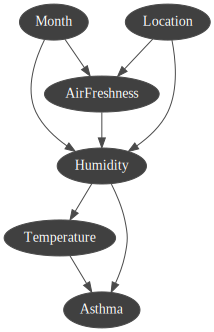

In [46]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Create a Bayesian Network
bn = gum.BayesNet("AsthmaPrediction")

# Add Nodes
bn.add(gum.LabelizedVariable("Location", "Location of person", 3))
bn.add(gum.LabelizedVariable("Month", "Month of the year", 12))
bn.add(gum.LabelizedVariable("AirFreshness", "Air Quality Index", 3))
bn.add(gum.LabelizedVariable("Humidity", "Humidity Levels", 5))
bn.add(gum.LabelizedVariable("Temperature", "Temperature Levels", 5))
bn.add(gum.LabelizedVariable("Asthma", "Asthma presence", 2))  # 0: No, 1: Yes

# Add Edges (Dependencies)
bn.addArc("Location", "AirFreshness")
bn.addArc("Month", "AirFreshness")
bn.addArc("Location", "Humidity")
bn.addArc("AirFreshness", "Humidity")
bn.addArc("Month", "Humidity")
bn.addArc("Humidity", "Temperature")
bn.addArc("Temperature", "Asthma")
bn.addArc("Humidity", "Asthma")

# Display the Graph
gnb.showBN(bn)


In [ ]:
bn.add(gum.LabelizedVariable("Asthma", "Presence of Asthma", 2))  # Binary variable (Yes/No)

In [ ]:
bn.addArc("Humidity", "Asthma")
bn.addArc("Temperature", "Asthma")

In [ ]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

# Display Conditional Probability Table (CPT) for Asthma
print(bn.cpt("Asthma"))  # Prints the table in text format

# Alternatively, visualize it using pyAgrum
gnb.showPotential(bn.cpt("Asthma"))
